# **2D Denoising pipeline**
___  
  
In this notebook we show how to apply a [BiaPy](https://biapy.readthedocs.io/en/latest/) pipeline for **2D denoising** of microscopy data.

<figure>
<center>
<img src='https://biapy.readthedocs.io/en/latest/_images/denosing_overview.svg' width='500px'/>
<figcaption><b>Figure 1</b>: Example of a 2D denoising problem. This image has been obtained from <a href="https://github.com/juglab/n2v">Noise2Void</a> project.</figcaption></center>
</figure>

**Without any coding**, we explain step by step how to
1. **upload a set of training and test images**,
2. **train a deep neural network (DNN)** model on the training set, 
3. **apply the model** to the test images, and 
4. **download the denoising results** to your local machine.

**Disclaimer:** The structure of the notebook is heavily inspired in the fantastic [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki).

**Contact:** This notebook has been made by [Ignacio Arganda-Carreras](mailto:ignacio.arganda@ehu.eus) and [Daniel Franco-Barranco](mailto:daniel.franco@dipc.org). If you have any suggestion or comment, or find any problem, please write us an email or [create an issue in BiaPy's repository](https://github.com/danifranco/BiaPy/issues). Thanks!

## **Expected inputs and outputs**
___
**Inputs**

This notebook expects three folders as input:
* **Training raw images**: with the raw 2D images to train the model.
* **Test raw images**: with the raw 2D images to test the model.
* **Output folder**: a path to store the denoising results.

**Outputs**

If the execution is successful, a folder will be created containing the denoising results. The resulting denoised files can be downloaded at the end of the notebook.

<font color='red'><b>Note</b></font>: for testing purposes, you can also run this notebook with the **example datasets provided in 'Manage file(s) source > Option 3**.






## **Prepare the environment**
___

Establish connection with Google services. You **must be logged in to Google** to continue.
Since this is not Google's own code, you will probably see a message warning you of the dangers of running unfamiliar code. This is completely normal.


## **Manage file(s) source**
---
The input folder can be provided using three different options: by directly uploading the folder (option 1), by using a folder stored in Google Drive (option 2) or by using a few samples of our data (option 3).

Depending on the option chosen, different steps will have to be taken, as explained in the following cells.


### **Option 1: use your local files and upload them to the notebook**
---
You will be prompted to upload your files to Colab and they will be stored under `/content/input/`. The file uploaded need to be a ZIP file containing train, val (if used) and test folders.

In [ ]:
#@markdown ##Play the cell to upload local files in a .zip file (train raw images)
from google.colab import files
!mkdir -p /content/input/train/
%cd /content/input/train/
uploaded = files.upload()
filename = list(uploaded.keys())[0]
if not filename.endswith('.zip'):
    raise ValueError("{} file uploaded has not .zip extension".format(filename))
!unzip -q {filename}
%cd /content

### **Option 2: mount your Google Drive**
---
To use this notebook on your own data from Google Drive, you need to mount Google Drive first.

Play the cell below to mount your Google Drive and follow the link that will be shown. In the new browser window, select your drive and select 'Allow', copy the code, paste into the cell and press enter. This will give Colab access to the data on the drive. 

Once this is done, your data are available in the **Files** tab on the top left of notebook.

In [ ]:
#@markdown ##Play the cell to connect your Google Drive to Colab

#@markdown * Click on the URL. 

#@markdown * Sign in your Google Account. 

#@markdown * Copy the authorization code. 

#@markdown * Enter the authorization code. 

#@markdown * Click on "Files" site on the right. Refresh the site. Your Google Drive folder should now be available here as "drive". 

# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

### **Option 3: download an example dataset**
---
If you do not have data at hand but would like to test the notebook, no worries! You can run the following cell to download an example dataset.

In particular, we will use a particular an image from [Noise2Void](https://github.com/juglab/n2v), concretely is and image of C. majalis acquired by Britta Schroth-Diez of the MPI-CBG Light Microscopy Facility.

In [1]:
#@markdown ##Play to download an example dataset

import os

os.chdir('/content/')

!curl -L -s -o convallaria2D.zip 'https://drive.google.com/uc?id=1TFvOySOiIgVIv9p4pbHdEbai-d2YGDvV&confirm=t'
!unzip -q convallaria2D.zip
!rm convallaria2D.zip

print('Dataset downloaded and unzipped under /content/data')


Dataset downloaded and unzipped under /content/data



## **Check for GPU access**
---

By default, the session should be using Python 3 and GPU acceleration, but it is possible to ensure that these are set properly by doing the following:

Go to **Runtime -> Change the Runtime type**

**Runtime type: Python 3** *(Python 3 is programming language in which this program is written)*

**Accelerator: GPU** *(Graphics processing unit)*

## **Paths to load input images and save output files**
___

If option 1 (uploading the folder) or option 3 (downloading our prepared data samples) were chosen, define train_data_path as '/content/data/train', val_data_path as '/content/data/val' (if not using validation from train which can be ignored if so), test_data_path as '/content/data/test' and output_path as '/content/out'. Please make sure you download the results from the '/content/out' folder later!

If option 2 is chosen, introduce here the paths to your input files and to the folder where you want to store the results. E.g. '/content/gdrive/MyDrive/...'.

In case you have troubles finding the path to your folders, at the top left of this notebook you will find a small folder icon. Explore until you find the folders. There you can copy the folder path by right clicking and clicking "copy".

In [2]:
#@markdown #####Path to train images
train_data_path = '/content/data/train' #@param {type:"string"}
#@markdown #####Path to test images
test_data_path = '/content/data/test' #@param {type:"string"}
#@markdown #####Path to store the resulting images (it'll be created if not existing):
output_path = '/content/output' #@param {type:"string"}

## **Install BiaPy library**


In [3]:
#@markdown ##Play to install BiaPy and its dependences

import os
import sys
import numpy as np
from tqdm.notebook import tqdm
from skimage.io import imread
from skimage.exposure import match_histograms                                                                           

# Clone the repo
os.chdir('/content/')
if not os.path.exists('BiaPy'):
    !git clone https://github.com/danifranco/BiaPy.git
    !git checkout b3a0cce3c8d07217a7bf8723bc15cb1745154cc9 &> /dev/null
    !pip install --upgrade --no-cache-dir gdown &> /dev/null
    sys.path.insert(0, 'BiaPy')
    os.chdir('/content/BiaPy')
    
    # Install dependencies 
    !pip install git+https://github.com/aleju/imgaug.git &> /dev/null
    !pip install numpy_indexed yacs fill_voids &> /dev/null
else:
    print( 'Using existing installed version of BiaPy' )

Cloning into 'BiaPy'...
remote: Enumerating objects: 15752, done.
remote: Counting objects: 100% (1821/1821), done.
remote: Compressing objects: 100% (565/565), done.
remote: Total 15752 (delta 1284), reused 1768 (delta 1237), pack-reused 13931
Receiving objects: 100% (15752/15752), 821.17 MiB | 17.06 MiB/s, done.
Resolving deltas: 100% (8553/8553), done.


## **Configure and train the DNN model**
[BiaPy](https://biapy.readthedocs.io/en/latest/) contains a few deep learning models to perform denoising.

The selection of the model and the pipeline hyperparameters can be configured by editing the YAML configuration file or (easier) by running the next cell.



### **Select your parameters**
---
#### **Name of the model**
* **`model_name`:** Use only my_model -style, not my-model (Use "_" not "-"). Do not use spaces in the name. Avoid using the name of an existing model (saved in the same folder) as it will be overwritten.

#### **Basic training parameters**
* **`number_of_epochs`:** Input how many epochs (rounds) the network will be trained. For the example dataset, reasonable results can already be observed after 100 epochs. **Default value: 200**

* **`percentage_validation`:**  Input the percentage of your training dataset you want to use to validate the network during the training. **Default value: 10**

* **`patience`:**  Input how many epochs you want to wait without the model improving its results in the validation set to stop training. **Default value: 20**

#### **Advanced Parameters - experienced users only**
* **`model_architecture`:**  Select the architecture of the DNN used as backbone of the pipeline. Options: U-Net, Residual U-Net, Attention U-Net and SEUNet [(see Franco-Barranco et al., 2021)](https://link.springer.com/article/10.1007/s12021-021-09556-1). **Default value: U-Net**

* **`batch_size:`** This parameter defines the number of patches seen in each training step. Reducing or increasing the **batch size** may slow or speed up your training, respectively, and can influence network performance. **Default value: 128**

* **`patch_size`:** Input the size of the patches use to train your model (length in pixels in X and Y). The value should be smaller or equal to the dimensions of the image. **Default value: 64**

* **`input_channels`:** Input the number of channels of your images (grayscale = 1, RGB = 3). **Default value: 1**

* **`optimizer`:** Select the optimizer used to train your model. Options: ADAM, Stocastic Gradient Descent (SGD). ADAM converges usually faster but SGD is known for better generalization. **Default value: ADAM**

* **`initial_learning_rate`:** Input the initial value to be used as learning rate. If you select ADAM as optimizer, this value should be around 10e-4. **Default value: 0.0004**

#### **Noise2Void parameters**
* **`n2v_perc_pix`:**  The fraction of pixels manipulated per each patch used for training. For instances, 0.198% of the input pixels per patch or a patch size of 64 by 64 pixels corresponds to about 8 pixels. **Default value: 0.198**

* **`pixel_manipulator:`** Controls how the pixels are going to be manipulated to train the network. **Default value: uniform_withCP**

* **`neighborhood_radius`:** Size of the neighborhood to compute the replacement. **Default value: 5**

* **`apply_structmask`:** Wheter to apply a structured mask as is proposed in [Noise2Void](https://github.com/juglab/n2v) to alleviate the limitation of the method of not removing efectively the structured noise (section 4.4 of their paper). **Default value: True**


In [13]:
#@markdown ###Name of the model:
model_name = "my_2d_denoising" #@param {type:"string"}

#@markdown ### Basic training parameters:
number_of_epochs =  200#@param {type:"number"}
percentage_validation =  10 #@param {type:"number"}
patience =  20#@param {type:"number"}

#@markdown ### Advanced training parameters:

model_architecture = "unet" #@param ['unet', 'resunet', 'seunet', 'attention_unet']

batch_size =  128#@param {type:"number"}
patch_size = 64 #@param {type:"number"}

input_channels = 1 #@param {type:"number"}

optimizer = "ADAM" #@param ["ADAM", "SGD"]
initial_learning_rate = 0.0004 #@param {type:"number"}

#@markdown ### Noise2Void parameters:

n2v_perc_pix = 0.198 #@param {type:"number"}
pixel_manipulator =  'uniform_withCP' #@param ['uniform_withCP','normal_withoutCP', 'mean', 'median', 'uniform_withoutCP','normal_additive','normal_fitted','identity']
neighborhood_radius = 5 #@param {type:"number"}
apply_structmask = True #@param {type:"boolean"}

In [14]:
#@markdown ##Play to download the YAML configuration file and update it to train the model
import errno

os.chdir('/content/') 

job_name = model_name
yaml_file = "/content/"+str(job_name)+".yaml"

# remove previous configuration file if it exists with the same name
if os.path.exists( yaml_file ):
    os.remove( yaml_file )

# Download template file 
import shutil
shutil.copy("/content/BiaPy/templates/denoising/n2v_2d_denoising.yaml", yaml_file)

# Check files before modifying the .yaml file
if not os.path.exists(train_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), train_data_path)
ids = sorted(next(os.walk(train_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(train_data_path))

if not os.path.exists(test_data_path):
    raise FileNotFoundError(errno.ENOENT, os.strerror(errno.ENOENT), test_data_path)
ids = sorted(next(os.walk(test_data_path))[2])
if len(ids) == 0:
    raise ValueError("No files found in dir {}".format(test_data_path))


# open template configuration file
import yaml
with open( yaml_file, 'r') as stream:
    try:
        biapy_config = yaml.safe_load(stream)
    except yaml.YAMLError as exc:
        print(exc)

# update paths to data
biapy_config['DATA']['TRAIN']['PATH'] = train_data_path
biapy_config['DATA']['TEST']['PATH'] = test_data_path

# update data patch size
biapy_config['DATA']['PATCH_SIZE'] = '('+str(patch_size)+', '+ str(patch_size)+', ' + str(input_channels)+')'
# adjust test padding accordingly
padding = patch_size // 8
biapy_config['DATA']['TEST']['PADDING'] = '('+str(padding)+', '+ str(padding)+')'

# update training parameters
biapy_config['DATA']['VAL']['FROM_TRAIN'] = True
biapy_config['DATA']['VAL']['SPLIT_TRAIN'] = percentage_validation/100.0
biapy_config['TRAIN']['EPOCHS'] = number_of_epochs
biapy_config['TRAIN']['PATIENCE'] = patience
biapy_config['TRAIN']['BATCH_SIZE'] = batch_size
biapy_config['TRAIN']['OPTIMIZER'] = optimizer
biapy_config['TRAIN']['LR'] = initial_learning_rate

# update N2V parameters
biapy_config['PROBLEM']['DENOISING']['N2V_PERC_PIX'] = n2v_perc_pix
biapy_config['PROBLEM']['DENOISING']['N2V_MANIPULATOR'] = pixel_manipulator
biapy_config['PROBLEM']['DENOISING']['N2V_NEIGHBORHOOD_RADIUS'] = neighborhood_radius
biapy_config['PROBLEM']['DENOISING']['N2V_STRUCTMASK'] = apply_structmask

# Transcribe model architecture
architecture = 'unet'
if model_architecture == "U-Net":
    architecture = 'unet'
elif model_architecture == "Residual U-Net":
    architecture = 'resunet'
elif model_architecture == "Attention U-Net":
    architecture = 'attention_unet'
elif model_architecture == "SEUNet":
    architecture = 'seunet'
biapy_config['MODEL']['ARCHITECTURE'] = architecture

# save file
with open( yaml_file, 'w') as outfile:
    yaml.dump(biapy_config, outfile, default_flow_style=False)

print( "Training configuration finished.")

Training configuration finished.


### **Train the model**
---

In [15]:
#@markdown ##Play to train the model

import os
import errno

# Run the code 
os.chdir('/content/BiaPy')
!python -u main.py --config '/content/'{job_name}'.yaml' --result_dir {output_path} --name {job_name} --run_id 1 --gpu 0



Date: 2023-01-29 11:11:20
Arguments: Namespace(config='/content/my_2d_denoising.yaml', gpu='0', name='my_2d_denoising', result_dir='/content/output', run_id=1)
Job: my_2d_denoising_1
Python       : 3.8.10 (default, Nov 14 2022, 12:59:47) 
Keras        : 2.9.0
Tensorflow   : 2.9.2
Num GPUs Available:  1
Configuration details:
AUGMENTOR:
  AFFINE_MODE: constant
  AUG_NUM_SAMPLES: 10
  AUG_SAMPLES: True
  BRIGHTNESS: False
  BRIGHTNESS_EM: False
  BRIGHTNESS_EM_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_EM_MODE: 3D
  BRIGHTNESS_FACTOR: (-0.1, 0.1)
  BRIGHTNESS_MODE: 3D
  CBLUR_DOWN_RANGE: (2, 8)
  CBLUR_INSIDE: True
  CBLUR_SIZE: (0.2, 0.4)
  CHANNEL_SHUFFLE: False
  CMIX_SIZE: (0.2, 0.4)
  CNOISE_NB_ITERATIONS: (1, 3)
  CNOISE_SCALE: (0.05, 0.1)
  CNOISE_SIZE: (0.2, 0.4)
  CONTRAST: False
  CONTRAST_EM: False
  CONTRAST_EM_FACTOR: (-0.1, 0.1)
  CONTRAST_EM_MODE: 3D
  CONTRAST_FACTOR: (-0.1, 0.1)
  CONTRAST_MODE: 3D
  COUT_APPLY_TO_MASK: False
  COUT_CVAL: 0
  COUT_NB_ITERATIONS: (1, 3)
  COUT_SIZE

## Inspection of the loss function and Mean Squared Error (MSE)
---

First, it is good practice to evaluate the training progress by comparing the training loss with the validation loss. The latter is a metric which shows how well the network performs on a subset of unseen data which is set aside from the training dataset. For more information on this, see for example [this review](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6381354/) by Nichols *et al.*

**Training loss** describes an error value after each epoch for the difference between the model's prediction and its ground-truth target.

**Validation loss** describes the same error value between the model's prediction on a validation image and compared to it's target.

During training both values should decrease before reaching a minimal value which does not decrease further even after more training. Comparing the development of the validation loss with the training loss can give insights into the model's performance.

Decreasing **Training loss** and **Validation loss** indicates that training is still necessary and increasing the `number_of_epochs` is recommended. Note that the curves can look flat towards the right side, just because of the y-axis scaling. The network has reached convergence once the curves flatten out. After this point no further training is required. If the **Validation loss** suddenly increases again an the **Training loss** simultaneously goes towards zero, it means that the network is overfitting to the training data. In other words the network is remembering the exact patterns from the training data and no longer generalizes well to unseen data. In this case the training dataset has to be increased.

The **MSE** metric is is a metric that generally describes how the model performs comparing the target and your prediction output.

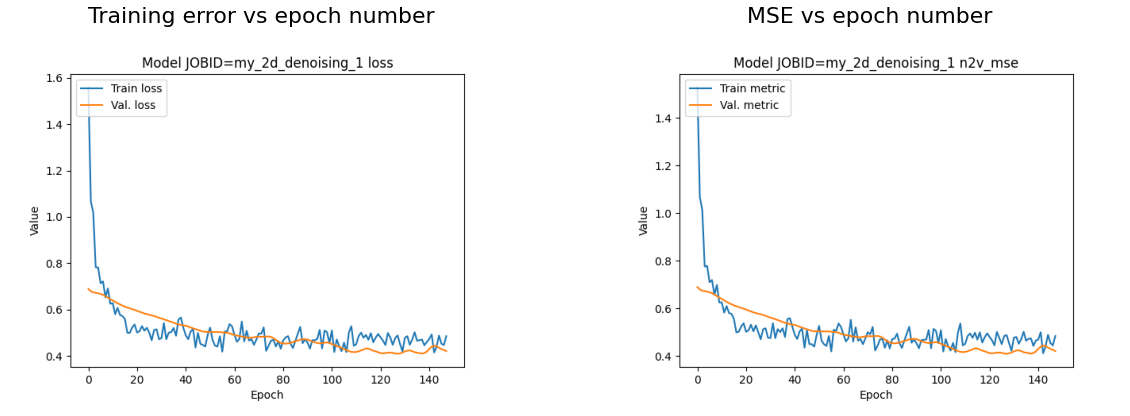

In [16]:
#@markdown ##Play the cell to show a plot of training error vs. epoch number and MSE vs epoch number
import matplotlib.pyplot as plt

loss_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_loss.png' )

iou_plot = imread( output_path + '/'+job_name+'/results/'+job_name+'_1/charts/'+job_name+'_1_n2v_mse.png' )

fig = plt.figure( figsize = (20,10))
ax1 = plt.subplot( 1, 2, 1 )
_ = plt.imshow( loss_plot )
_ = plt.axis('off')
ax1.set_title( 'Training error vs epoch number', fontdict = {'fontsize':22})

ax2 = plt.subplot( 1, 2, 2 )
_ = plt.imshow( iou_plot )
_ = plt.axis('off')
_= ax2.set_title( 'MSE vs epoch number', fontdict = {'fontsize':22})

## **Visualize denoising results**

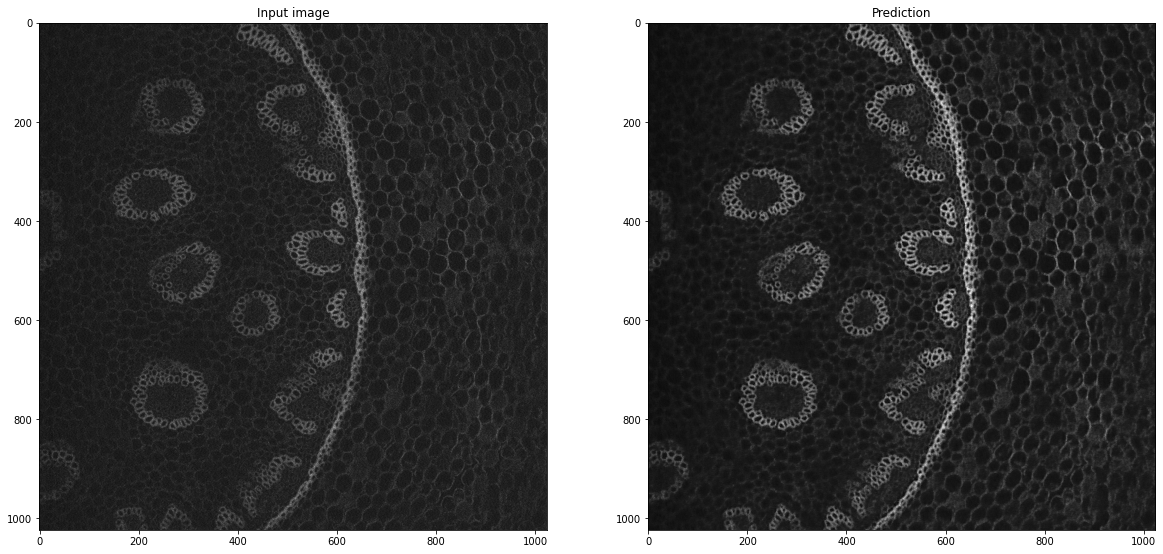

In [17]:
final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

if biapy_config['TEST']['STATS']['FULL_IMG'] == True:
    denoising_results = os.path.join(final_results, "full_image")
else:
    denoising_results = os.path.join(final_results, "per_image")

#@markdown ###Play to visualize some results
from IPython.display import Markdown as md
md("After this last step, the resulting images should be placed in {}".format(final_results))
# Show a few examples to check that they have been stored correctly 
%matplotlib inline
import matplotlib
import numpy as np
from numpy.random import randint, seed
from matplotlib import pyplot as plt

ids_pred = sorted(next(os.walk(denoising_results))[2])
ids_input = sorted(next(os.walk(test_data_path))[2])

samples_to_show = min(len(ids_input), 3)
chosen_images = np.random.choice(len(ids_input), samples_to_show, replace=False) 
seed(1)

test_samples = []
test_sample_preds = []

for i in range(len(chosen_images)):
    aux = imread(os.path.join(test_data_path, ids_input[chosen_images[i]]))
    test_samples.append(aux)
    
    aux = imread(os.path.join(denoising_results, ids_pred[chosen_images[i]])).astype(np.uint16)
    test_sample_preds.append(aux)

# Show predicted images
plt.figure(figsize=(20,15))
index = 1
for j in range(samples_to_show):
    plt.subplot(samples_to_show, 2, index)
    plt.title("Input image")
    plt.imshow(test_samples[j], cmap='gray')          
    
    index = index + 1
    plt.subplot(samples_to_show, 2, index)
    plt.title("Prediction")
    plt.imshow(test_sample_preds[j], cmap='gray', interpolation='nearest')
    
plt.show()

In [9]:
#@markdown ###Play to display the path to the output denoised files

final_results = os.path.join(output_path, job_name, 'results', job_name+"_1")

denoising_results = os.path.join(final_results, "per_image")

print("Output paths:")
print("    Predicted test denoised images are in {}".format(denoising_results))

Output paths:
    Predicted test denoised images are in /content/output/my_2d_denoising/results/my_2d_denoising_1/per_image


## **Download denoising results**

In [10]:
#@markdown ###Play to download all denoising results in test.

from google.colab import files


!zip -q -j /content/denoising.zip $denoising_results/*.tif

files.download("/content/denoising.zip")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Download train model (weights and configuration file)**
If you want to **reuse the train model in the future**, you can download both the model weights and its configuration file (.YAML) by running the following cells.

In [11]:
#@markdown ###Play to download the model weights

checkpoints_path = os.path.join(output_path, job_name, 'checkpoints')

weights_filename = 'model_weights_' + str( job_name ) + '_1.h5'

files.download( os.path.join( checkpoints_path, weights_filename))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [12]:
#@markdown ###Play to download the model configuration file (.YAML)

config_path = os.path.join(output_path, job_name, 'config_files')

files.download( os.path.join( config_path, yaml_file))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## **Acknowledgments**
We would like to acknowledge the inspiration provided by the excellent [ZeroCostDL4Mic notebooks](https://github.com/HenriquesLab/ZeroCostDL4Mic/wiki). In particular, we have reused some of their descriptions of metrics and parameters.